# Homework 3
### Name: William Martinez
### Collaborators: None

Due date: May 19, 2024

Submission instructions: 
- __Autograder will not be used for scoring, but you still need to submit the python file converted from this notebook (.py) and the notebook file (.ipynb) to the code submission window.__ 
To convert a Jupyter Notebook (`.ipynb`) to a regular Python script (`.py`):
  - In Jupyter Notebook: File > Download as > Python (.py)
  - In JupyterLab: File > Save and Export Notebook As... > Executable Script
  - In VS Code Jupyter Notebook App: In the toolbar, there is an Export menu. Click on it, and select Python script.
- Submit `hw3.ipynb` and `hw3.py` on Gradescope under the window "Homework 3 - code". Do **NOT** change the file name.
- Convert this notebook into a pdf file and submit it on Gradescope under the window "Homework 3 - PDF". Make sure all your code and text outputs in the problems are visible. 


This homework requires two new packages, `pyarrow` and `duckdb`. Pleas make sure to install them in your `BIOSTAT203C-24S` environment:

```bash
conda activate BIOSTAT203C-24S
conda install -c conda-forge pyarrow python-duckdb
```

In [1]:
import sys
import gzip
import time
import random
import duckdb
import numpy as np
import pandas as pd
import polars as pl
import pyarrow as pa
import pyarrow.csv as csv
import pyarrow.compute as pc
import pyarrow.parquet as pq
from matplotlib import pyplot as plt

# Create a syslink named `mimic` in working directory.
pth_hsp = './mimic/hosp/'
pth_icu = './mimic/icu/'

# Common Objects. Added here in case of kernel crash.
lab_col = ['subject_id', 'itemid', 'charttime', 'valuenum']
lab_itemid = [50912, 50971, 50983, 50902, 50882, 51221, 51301, 50931]

## Problem 1. 

Recall the simple random walk.  At each step, we flip a fair coin. If heads, we move "foward" one unit; if tails, we move "backward." 

### (A).

Way back in Homework 1, you wrote some code to simulate a random walk in Python. 

Start with this code, or use posted solutions for HW1. If you have since written random walk code that you prefer, you can use this instead. Regardless, take your code, modify it, and enclose it in a function `rw()`. This function should accept a single argument `n`, the length of the walk. The output should be a list giving the position of the random walker, starting with the position after the first step. For example, 

```python
rw(5)
[1, 2, 3, 2, 3]
```

Unlike in the HW1 problem, you should not use upper or lower bounds. The walk should always run for as long as the user-specified number of steps `n`. 

Use your function to print out the positions of a random walk of length `n = 10`. 

Don't forget a helpful docstring!

### ANSWER 1A

In [2]:
def rw(n):
  """
  A list of positions from a random walk.
  ---
  Args:
    n: A positive integer. Number of steps.
  Returns:
    positions: A list of poistions.
  """
  pos = 0 # Initialized current position
  positions = [] # Empty list. Track positions after a step.
  while len(positions) < n:
    x = random.choice(["heads", "tails"])
    if x == "heads":
        pos += 1 # If heads, move forward one step.
        positions.append(pos) # Append position after step.
    elif x == "tails":
        pos -= 1 # If tails, move backward one step.
        positions.append(pos) # Append position after step.
  return positions

rw(10)
    

[-1, -2, -3, -2, -1, 0, 1, 2, 1, 0]

### (B). 

Now create a function called `rw2(n)`, where the argument `n` means the same thing that it did in Part A. Do so using `numpy` tools. Demonstrate your function as above, by creating a random walk of length 10. You can (and should) return your walk as a `numpy` array. 

**Requirements**: 

- No for-loops. 
- This function is simple enough to be implemented as a one-liner of fewer than 80 characters, using lambda notation. Even if you choose not to use lambda notation, the body of your function definition should be no more than three lines long. Importing `numpy` does not count as a line. 
- A docstring is required if and only if you take more than one line to define the function. 

**Hints**:

- Check the documentation for `np.random.choice()`. 
- `np.cumsum()`. 


### Answer 1B

In [3]:
# Return positions from n random steps
rw2 = lambda n: np.random.choice([-1, 1], size=n, replace=True).cumsum()

rw2(10)


array([-1,  0,  1,  0,  1,  0,  1,  0,  1,  2])

### (C).

Use the `%timeit` magic macro to compare the runtime of `rw()` and `rw2()`. Test how each function does in computing a random walk of length `n = 10000`. 

### Answer 1C

In [4]:
%%timeit
rw(10_000)

3.78 ms ± 24.9 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [5]:
%%timeit
rw2(10_000)

61.3 µs ± 203 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


### (D). 

Write a few sentences in which you comment on (a) the performance of each function and (b) the ease of writing and reading each function. 

### ANSWER 1D

The function, `rw2()`, was 82% faster than the function, `rw()`. Built-in python list operations were used in `rw()` and numpy array operations were used in `rw2()`. The average run-times for `rw()` and `rw2()` were 61.1 µs and 362 µs, respectively. The numpy array function, `rw2()`, was easier to write, occupying only one line, and was more readable than the built-in python list operations in `rw()`.

### (E). 


In this problem, we will perform a `d`-dimensional random walk. There are many ways to define such a walk. Here's the definition we'll use for this problem: 

> At each timestep, the walker takes one random step forward or backward **in each of `d` directions.** 

For example, in a two-dimensional walk on a grid, in each timestep the walker would take a step either north or south, and then another step either east or west. Another way to think about is as the walker taking a single "diagonal" step either northeast, southeast, southwest, or northwest. 

Write a function called `rw_d(n,d)` that implements a `d`-dimensional random walk. `n` is again the number of steps that the walker should take, and `d` is the dimension of the walk. The output should be given as a `numpy` array of shape `(n,d)`, where the `k`th row of the array specifies the position of the walker after `k` steps. For example: 

```python
P = rw_d(5, 3)
P
```
```
array([[-1, -1, -1],
       [ 0, -2, -2],
       [-1, -3, -3],
       [-2, -2, -2],
       [-1, -3, -1]])
```

In this example, the third row `P[2,:] = [-1, -3, -3]` gives the position of the walk after 3 steps. 

Demonstrate your function by generating a 3d walk with 5 steps, as shown in the example above. 

All the same requirements and hints from Part B apply in this problem as well. It should be possible to solve this problem by making only a few small modifications to your solution from Part B. If you are finding that this is not possible, you may want to either (a) read the documentation for the relevant `numpy` functions more closely or (b) reconsider your Part B approach. 





### Answer 1E

In [6]:
def rw_d(n, d):
  """
  A list of positions from a multidimential random walk.
  ---
  Args:
    n: A positive integer. The number of steps in each dimention.
    d: A positive integer. The number of dimentions.
  Return:
    positions: An numpy array. The positions after step in a dimention.
  """
  positions = (
    np.random.choice(
      [-1, 1], # -1 for tails and 1 for heads.
      size = (n * d), # The number of elements in array.
      replace = True) # Reuse heads and tails.
    .reshape(n, d) # Reshape into n rows and d columns.
    .cumsum(axis=0) # Columnar Cumulative Sum 
  )
  return positions

rw_d(5, 3)

array([[-1, -1,  1],
       [-2, -2,  0],
       [-1, -3,  1],
       [-2, -4,  2],
       [-3, -3,  3]])

### (F).

In a few sentences, describe how you would have solved Part E without `numpy` tools. Take a guess as to how many lines it would have taken you to define the appropriate function. Based on your findings in Parts C and D, how would you expect its performance to compare to your `numpy`-based function from Part E? Which approach would your recommend? 

Note: while I obviously prefer the `numpy` approach, it is reasonable and valid to prefer the "vanilla" way instead. Either way, you should be ready to justify your preference on the basis of writeability, readability, and performance. 

### Answer 1F

Without using numpy tools, Part E could be solved by creating a 2-D list. Use a for-loop to call `rw()`  d times with an input of n. For each iteration, zip the old list with the new list. Results in an array shape of (n,d). The resulting function would be approximately 9 lines long (20 lines including `rw()`) and would have a longer runtime than if numpy tools were used. The numpy based function from part E 5-10 times faster than the non-numpy function proposed. Therefore, the utilization of numpy tooling is preferred for its readability and  speed.

### (G).

Once you've implemented `rw_d()`, you can run the following code to generate a large random walk and visualize it. 

```python
from matplotlib import pyplot as plt

W = rw_d(20000, 2)
plt.plot(W[:,0], W[:,1])
```

You may be interested in looking at several other visualizations of multidimensional random walks [on Wikipedia](https://en.wikipedia.org/wiki/Random_walk). Your result in this part will not look exactly the same, but should look qualitatively fairly similar. 

You only need to show one plot. If you like, you might enjoy playing around with the plot settings. While `ax.plot()` is the normal method to use here, `ax.scatter()` with partially transparent points can also produce some intriguing images. 

### Answer 1G

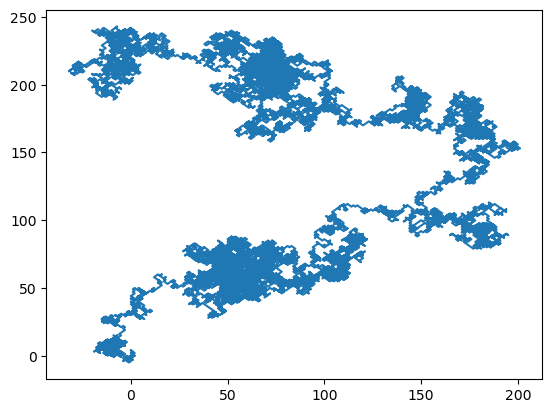

In [7]:
# Plot 2-D Random Walk
W = rw_d(20000, 2)
plt.plot(W[:,0], W[:,1])

## Problem 2. Reading MIMIC-IV datafile
In this exercise, we explore various tools for ingesting the [MIMIC-IV](https://mimic.mit.edu/docs/iv/) data introduced in BIOSTAT 203B, but we will do it in Python this time.

Let's display the contents of MIMIC `hosp` and `icu` data folders: (if a cell starts with a `!`, the command is run in the shell.)

### Directions To Setup Mimic

- Create a system link (`ln -s`) between Mimic and the current working directory of this notebook. Using a system link is storage efficient and allows for more readable relative paths to be used to reference the mimic data.

- Use the tags `-goh` to show permissions, size, and filename.

In [8]:
# Hosp Files
!ls -goh ./mimic/hosp/

total 8859752
-rw-------@ 1     15M Jan  5  2023 admissions.csv.gz
-rw-------@ 1    417K Jan  5  2023 d_hcpcs.csv.gz
-rw-------@ 1    839K Jan  5  2023 d_icd_diagnoses.csv.gz
-rw-------@ 1    565K Jan  5  2023 d_icd_procedures.csv.gz
-rw-------@ 1     13K Jan  5  2023 d_labitems.csv.gz
-rw-------@ 1     24M Jan  5  2023 diagnoses_icd.csv.gz
-rw-------@ 1    7.1M Jan  5  2023 drgcodes.csv.gz
-rw-------@ 1    485M Jan  5  2023 emar.csv.gz
-rw-------@ 1    449M Jan  5  2023 emar_detail.csv.gz
-rw-------@ 1    1.7M Jan  5  2023 hcpcsevents.csv.gz
-rw-------@ 1    1.8G Jan  5  2023 labevents.csv.gz
-rw-------@ 1     92M Jan  5  2023 microbiologyevents.csv.gz
-rw-------@ 1     34M Jan  5  2023 omr.csv.gz
-rw-------@ 1    2.2M Jan  5  2023 patients.csv.gz
-rw-------@ 1    380M Jan  5  2023 pharmacy.csv.gz
-rw-------@ 1    475M Jan  5  2023 poe.csv.gz
-rw-------@ 1     24M Jan  5  2023 poe_detail.csv.gz
-rw-------@ 1    438M Jan  5  2023 prescriptions.csv.gz
-rw-------@ 1    5.7M Jan  5  2023 

In [9]:
# ICU Files
!ls -goh ./mimic/icu/

total 6155968
-rw-------@ 1     35K Jan  5  2023 caregiver.csv.gz
-rw-------@ 1    2.3G Jan  5  2023 chartevents.csv.gz
-rw-------@ 1     56K Jan  5  2023 d_items.csv.gz
-rw-------@ 1     44M Jan  5  2023 datetimeevents.csv.gz
-rw-------@ 1    2.5M Jan  5  2023 icustays.csv.gz
-rw-------@ 1    240M Jan  5  2023 ingredientevents.csv.gz
-rw-------@ 1    309M Jan  5  2023 inputevents.csv.gz
-rw-------@ 1     37M Jan  5  2023 outputevents.csv.gz
-rw-------@ 1     20M Jan  5  2023 procedureevents.csv.gz


### (A). Speed, memory, and data types

Standard way to read a CSV file would be using the `read_csv` function of the `pandas` package. Let us check the speed of reading a moderate-sized compressed csv file, `admissions.csv.gz`. How much memory does the resulting data frame use?

_Note:_ If you start a cell with `%%time`, the runtime will be measured. 

In [12]:
def percent_diff(i_time=None, f_time=None, i_mem=None, f_mem=None):
  """
  Print Pandas and Polars Comparison Metrics
  ---
  Args:
    i_time: A positive float. The runtime of a initial cell in s.
    f_time: A positive float. The runtime of a final cell in s.
  Optional Args:
    i_mem: A positive float. Initial dataframe object memory usage in GB.
    f_mem: A positive float. Final dataframe object memory usage in GB.
  Return:
    None
  """
  if (i_time is not None) and (f_time is not None): # Check if empty
    time_diff = round((f_time - i_time) / i_time * 100) # percent diff.
    if time_diff > 0: # if percent diff. is greater than 0 output text
      print(f"final runtime was {abs(time_diff)}% slower than initial.")
    elif time_diff < 0: # if percent diff. is less than 0 output text
      print(f"final runtime was {abs(time_diff)}% faster than initial.")
    elif time_diff == 0: # if percent diff. is equal to 0 output text
      print(f"final runtime was the same as initial.")
    else:
      raise TypeError
  else:
    pass
  if (i_mem is not None) and (f_mem is not None): # Check if empty
    mem_diff = round((f_mem - i_mem) / i_mem * 100) # percent diff
    if mem_diff > 0: # if percent diff. is greater than 0 output text
      print(f"final df memory usage was {abs(mem_diff)}% more than initial.")
    elif mem_diff < 0: # if percent diff. is less than 0 output text
      print(f"final df memory usage was {abs(mem_diff)}% less than initial.")
    elif mem_diff == 0: # if percent diff. is equal to 0 output text
      print(f"final df memory usage was the same as initial.")
    else:
      raise TypeError
  else:
    pass

### Answer 2A

#### Pandas

The runtime to ingest `admissions.csv.gz` using pandas was 884 ms and the resulting data frame memory usage was 0.368 GB.

#### Polars

The runtime to ingest `admissions.csv.gz` using pandas was 214 ms and the resulting data frame memory usage was 4.8e-08 GB.

#### Summary

Polars consumed less resources than pandas. The Polars runtime was __34% faster__ and the Polars data frame object memory usage was __2% less__ than Pandas.

In [7]:
%%time
# Read admissions using Pandas
df_pd_adm = pd.read_csv("./mimic/hosp/admissions.csv.gz")

CPU times: user 747 ms, sys: 43.3 ms, total: 790 ms
Wall time: 806 ms


In [8]:
print(round(sys.getsizeof(df_pd_adm)/10**9, 3), "GB")

0.368 GB


In [3]:
%%time
# Read admissions using Polars
df_pl_adm = pl.read_csv("./mimic/hosp/admissions.csv.gz").to_pandas()

CPU times: user 540 ms, sys: 135 ms, total: 675 ms
Wall time: 525 ms


In [6]:
print(round(sys.getsizeof(df_pl_adm)/10**9, 3), "GB")

0.362 GB


In [13]:
# Initial: Pandas reading admissions.csv.gz
# Final: Polars reading admissions.csv.gz
percent_diff(i_time=0.806, i_mem=0.368, f_time=0.525, f_mem=0.362)

final runtime was 35% faster than initial.
final df memory usage was 2% less than initial.


In [16]:
del df_pd_adm
del df_pl_adm

### (B). User-supplied data types

Re-ingest `admissions.csv.gz` by indicating appropriate column data types in [`pd.read_csv`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html). Does the run time change? How much memory does the result dataframe use? (Hint: `dtype` and `parse_dates` arguments in `pd.read_csv`.)

### Answer 2B

#### Pandas (Categorical) 

Categorical variables were assigned as type `categorical`. Dates were assigned as date. The runtime to ingest `admissions.csv.gz` using pandas and declaring data types was 3.69 seconds and the resulting data frame memory usage was 0.029 GB. Compared to pandas reading without declaring data types (1A), the pandas runtime with declared data types was __331% slower__ but the data frame memory usage was __92% less__.

#### Pandas (String)

Categorical variables were assigned as type `string`. Dates were assigned as date. The runtime to ingest `admissions.csv.gz` using pandas and declaring data types was 3.76 seconds and the resulting data frame memory usage was 0.277 GB. Compared to pandas reading without declaring data types (1A), the pandas runtime with declared data types was __328% slower__ but the data frame memory usage was __25% less__.

#### Polars (Categorical)

Categorical variables were assigned as type `string`. Dates were assigned as date. The runtime to ingest `admissions.csv.gz` using polar and declaring data types was 0.207 seconds and the resulting data frame memory usage was 0.029 GB. Compared to pandas reading without declaring data types (1A), the pandas runtime with declared data types was __328% slower__ but the data frame memory usage was __604,165x more__.


#### Summary
For pandas, declaring variables increased the runtime but decreased the the size of the resulting data frame. Additionally, for pandas the size of the resulting data frame was less when categorical variables were assigned the type, `categorical`. Polars, had a slower runtime and larger resulting data frame; however, compared to pandas, the it was faster and the resulting data frame was smaller. Of the methods tested, polars was best because it accomplished the same task as pandas while using less resources.

In [17]:
%%time
# Pandas: Assigning data types while reading (category)
df_pd_cat_adm = pd.read_csv(
  "./mimic/hosp/admissions.csv.gz",
  # assign data types
  dtype={
    'subject_id': 'int64',
    'hadm_id': 'int64',
    'admission_type': 'category',
    'admit_provider_id': 'category',
    'admission_location': 'category',
    'discharge_location': 'category',
    'insurance': 'category',
    'language': 'category',
    'marital_status': 'category',
    'race': 'category',
    'hospital_expire_flag': 'category'
  },
  # assign date types
  parse_dates=[
    'admittime',
    'dischtime',
    'deathtime',
    'edregtime',
    'admittime',
    'edouttime',
    'deathtime',
  ]
)

CPU times: user 3.48 s, sys: 83.9 ms, total: 3.57 s
Wall time: 3.6 s


In [18]:
print(round(sys.getsizeof(df_pd_cat_adm)/10**9,3), "GB")

0.029 GB


In [19]:
# Initial = Pandas without declared data types
# Final = Pandas with declared data types (categorical)
percent_diff(i_time=0.878, i_mem=0.368, f_time=3.78, f_mem=0.029)

final runtime was 330.524% slower than initial.
final df memory usage was 92.12% less than initial.


In [20]:
%%time
# Pandas: Assigning data types while reading (string)
df_pd_str_adm = (
  pd.read_csv(
    "./mimic/hosp/admissions.csv.gz",
    # assign data types
    dtype={
      'subject_id': 'int64',
      'hadm_id': 'int64',
      'admission_type': 'string',
      'admit_provider_id': 'string',
      'admission_location': 'string',
      'discharge_location': 'string',
      'insurance': 'string',
      'language': 'string',
      'marital_status': 'string',
      'race': 'string',
      'hospital_expire_flag': 'string'
    },
    # assign date types
    parse_dates=[
      'admittime',
      'dischtime',
      'deathtime',
      'edregtime',
      'admittime',
      'edouttime',
      'deathtime',])
)

CPU times: user 3.46 s, sys: 69.4 ms, total: 3.53 s
Wall time: 3.54 s


In [21]:
print(round(sys.getsizeof(df_pd_str_adm)/10**9, 3), "GB")

0.277 GB


In [22]:
# Initial = Pandas without declared data types
# Final = Pandas with declared data types (string)
percent_diff(i_time=0.878, i_mem=0.368, f_time=3.76, f_mem=0.277)

final runtime was 328.246% slower than initial.
final df memory usage was 24.728% less than initial.


In [23]:
%%time
# Polars: Assigning data types while reading (category)
df_pl_cat_adm = (
  pl.read_csv(
    "./mimic/hosp/admissions.csv.gz", # read file
    # assign data types
    dtypes={ 
      'subject_id': pl.Int64,
      'hadm_id': pl.Int64,
      'admission_type': pl.Categorical,
      'admit_provider_id': pl.Categorical,
      'admission_location': pl.Categorical,
      'discharge_location': pl.Categorical,
      'insurance': pl.Categorical,
      'language': pl.Categorical,
      'marital_status': pl.Categorical,
      'race': pl.Categorical,
      'hospital_expire_flag': pl.Categorical}, 
    try_parse_dates=True) # convert columns to date.
  .to_pandas() # convert to pd.dataframe
)

CPU times: user 354 ms, sys: 28.3 ms, total: 383 ms
Wall time: 188 ms


In [24]:
print(round(sys.getsizeof(df_pl_cat_adm)/10**9,3), "GB")

0.029 GB


In [25]:
# Initial = Polars without declared data types(initial) 
# Final = Polars with declared data types
percent_diff(i_time=0.214, i_mem=4.8e-08, f_time=0.199, f_mem=0.029)

final runtime was 7.009% faster than initial.
final df memory usage was 60416566.667% more than initial.


In [26]:
del df_pd_cat_adm
del df_pd_str_adm
del df_pl_cat_adm

## Problem 3. Ingest big data files


Let us focus on a bigger file, `labevents.csv.gz`, which is about 125x bigger than `admissions.csv.gz`.

In [27]:
# Size of labevents as a csv.gz
!ls -goh ./mimic/hosp/labevents.csv.gz

-rw-------@ 1    1.8G Jan  5  2023 ./mimic/hosp/labevents.csv.gz


Display the first 10 lines of this file.

In [28]:
# First 10 results of labevents
!zcat < ./mimic/hosp/labevents.csv.gz | head -10

labevent_id,subject_id,hadm_id,specimen_id,itemid,order_provider_id,charttime,storetime,value,valuenum,valueuom,ref_range_lower,ref_range_upper,flag,priority,comments
1,10000032,,45421181,51237,P28Z0X,2180-03-23 11:51:00,2180-03-23 15:15:00,1.4,1.4,,0.9,1.1,abnormal,ROUTINE,
2,10000032,,45421181,51274,P28Z0X,2180-03-23 11:51:00,2180-03-23 15:15:00,___,15.1,sec,9.4,12.5,abnormal,ROUTINE,VERIFIED.
3,10000032,,52958335,50853,P28Z0X,2180-03-23 11:51:00,2180-03-25 11:06:00,___,15,ng/mL,30,60,abnormal,ROUTINE,NEW ASSAY IN USE ___: DETECTS D2 AND D3 25-OH ACCURATELY.
4,10000032,,52958335,50861,P28Z0X,2180-03-23 11:51:00,2180-03-23 16:40:00,102,102,IU/L,0,40,abnormal,ROUTINE,
5,10000032,,52958335,50862,P28Z0X,2180-03-23 11:51:00,2180-03-23 16:40:00,3.3,3.3,g/dL,3.5,5.2,abnormal,ROUTINE,
6,10000032,,52958335,50863,P28Z0X,2180-03-23 11:51:00,2180-03-23 16:40:00,109,109,IU/L,35,105,abnormal,ROUTINE,
7,10000032,,52958335,50864,P28Z0X,2180-03-23 11:51:00,2180-03-23 16:40:00,___,8,ng/mL,0,8.7,,ROUTI

### (A). Ingest `labevents.csv.gz` by `pd.read_csv`

Try to ingest `labevents.csv.gz` using `pd.read_csv`. What happens? If it takes more than 5 minutes on your computer, then abort the program and report your findings. 

### Answer 3A

#### Pandas

Pandas was able to read `labevents.csv.gz` within 5 minutes. The runtime to read the file was 3 minutes and 17 seconds and the resulting data frame memory usage was 61 GB.

#### Polars

Polars was unable to read `labevents.csv.gz` within 5 minutes. From problem, 4A, it was determined that polars doesn't read compressed csv files and convert them to pandas data frames efficiently for large compressed csv files. The kernel will crash.

#### Summary

Use Pandas to read in large (but less than memory) compressed files because polars is not efficient at reading large compressed files.

In [29]:
%%time
#Pandas read labevents.csv.gz
df_pd_lab = pd.read_csv("./mimic/hosp/labevents.csv.gz")

CPU times: user 1min 47s, sys: 31.9 s, total: 2min 18s
Wall time: 3min 6s


In [30]:
print(round(sys.getsizeof(df_pd_lab)/10**9,3), "GB")

61.002 GB


In [31]:
del df_pd_lab

In [32]:
%%time
#Polars read labevents.csv.gz Failed
# df_pl_lab = pl.read_csv("./mimic/hosp/labevents.csv.gz").to_pandas()

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.05 µs


In [33]:
# print(round(sys.getsizeof(df_pl_lab)/10**9,3), "GB")

In [34]:
# del df_pl_lab

### (B). Ingest selected columns of `labevents.csv.gz` by `pd.read_csv`

Try to ingest only columns `subject_id`, `itemid`, `charttime`, and `valuenum` in `labevents.csv.gz` using `pd.read_csv`.  Does this solve the ingestion issue? (Hint: `usecols` argument in `pd.read_csv`.)

### Answer 3B

#### Pandas

The runtime to read selected columns of the file was 1 minute and 12 seconds and the resulting data frame memory usage was 11.817 GB. The runtime for reading selected columns in pandas was __63% faster__ and the resulting data frame memory usage was __81% smaller__ when compared the pandas reading all columns.

#### Polars

The runtime to read selected columns of the file was 44.8 seconds and the resulting data frame memory usage was 11.817 GB. The runtime for reading selected columns in polars was __77% faster__ and the resulting data frame memory usage was __81% smaller__ when compared the pandas reading all columns.

#### Summary

For large, compressed files, pandas is the preferred method. Pandas increased compatibility, reliability, and readability outweigh the marginal performance increases provided by polars when reading large, compressed files.

In [35]:
%%time
# Pandas Read select labevent columns
df_pd_lab = pd.read_csv("./mimic/hosp/labevents.csv.gz", usecols = lab_col)

CPU times: user 1min 4s, sys: 2.36 s, total: 1min 6s
Wall time: 1min 6s


In [36]:
print(round(sys.getsizeof(df_pd_lab)/10**9,3), "GB")

11.817 GB


In [37]:
# Initial: Pandas reading all columns
# Final: Pandas reading selected columns
percent_diff(
  i_time= (3 * 60 + 17),
  i_mem= 61.002,
  f_time= (1 * 60 + 12),
  f_mem= 11.817
)

final runtime was 63.452% faster than initial.
final df memory usage was 80.629% less than initial.


In [38]:
del df_pd_lab

In [39]:
%%time
# Polars Read select labevent columns
df_pl_lab = (
  pl.read_csv("./mimic/hosp/labevents.csv.gz", # read file
    columns = lab_col) # Select columns
    .to_pandas() # Convert pl.dataframe to pd.dataframe
)

CPU times: user 35.5 s, sys: 15.6 s, total: 51.1 s
Wall time: 40.9 s


In [40]:
print(round(sys.getsizeof(df_pl_lab)/10**9,3), "GB")

11.817 GB


In [41]:
# Initial: Pandas reading all columns
# Final: Polars reading specific columns
percent_diff(
  i_time= (3 * 60 + 17),
  i_mem= 61.002,
  f_time= (44.8),
  f_mem= 11.817
)

final runtime was 77.259% faster than initial.
final df memory usage was 80.629% less than initial.


In [42]:
del df_pl_lab

### (C). Ingest subset of `labevents.csv.gz`

Back in BIOSTAT 203B, our first strategy to handle this big data file was to make a subset of the `labevents` data.  Read the [MIMIC documentation](https://mimic.mit.edu/docs/iv/modules/hosp/labevents/) for the content in data file `labevents.csv.gz`.

As before, we will only be interested in the following lab items: creatinine (50912), potassium (50971), sodium (50983), chloride (50902), bicarbonate (50882), hematocrit (51221), white blood cell count (51301), and glucose (50931) and the following columns: `subject_id`, `itemid`, `charttime`, `valuenum`. 

Rerun the Bash command to extract these columns and rows from `labevents.csv.gz` and save the result to a new file `labevents_filtered.csv.gz` in the current working directory (Q2.3 of HW2). How long does it take?

Display the first 10 lines of the new file `labevents_filtered.csv.gz`. How many lines are in this new file? How long does it take `pd.read_csv()` to ingest `labevents_filtered.csv.gz`?


### Answer 3C

The runtime to select columns and filter `labevents` using Bash was 5 minutes and 34 seconds and the runtime to ingest `labevents_filtered` was 7 seconds. The number of rows in the resulting dataset was 24,855,909.

In [43]:
%%bash
# Read labevents, select columns, and filter rows by itemid
time(zcat < ./mimic/hosp/labevents.csv.gz | \
  awk -F, \
  'BEGIN {OFS = ","} {if (NR == 1 || $5 == 50912 || $5 == 50971 ||
    $5 == 50983 || $5 == 50902 || $5 == 50882 || $5 == 51221 || 
    $5 == 51301 || $5 == 50931) {print $2, $5, $7, $10}}' | \
  gzip > labevents_filtered.csv.gz)
echo "complete"


real	5m20.174s
user	5m47.115s
sys	0m2.754s


complete


In [44]:
%%time
# Pandas read labevents_filtered.csv.gz
df_pd_lab_filter = pd.read_csv("./labevents_filtered.csv.gz")

CPU times: user 6.26 s, sys: 319 ms, total: 6.58 s
Wall time: 6.67 s


In [45]:
df_pd_lab_filter.head(10)

,subject_id,itemid,charttime,valuenum
0,10000032,50882,2180-03-23 11:51:00,27.0
1,10000032,50902,2180-03-23 11:51:00,101.0
2,10000032,50912,2180-03-23 11:51:00,0.4
3,10000032,50971,2180-03-23 11:51:00,3.7
4,10000032,50983,2180-03-23 11:51:00,136.0
5,10000032,50931,2180-03-23 11:51:00,95.0
6,10000032,51221,2180-03-23 11:51:00,45.4
7,10000032,51301,2180-03-23 11:51:00,3.0
8,10000032,51221,2180-05-06 22:25:00,42.6
9,10000032,51301,2180-05-06 22:25:00,5.0


In [46]:
df_pd_lab_filter.shape

(24855909, 4)

In [47]:
print(round(sys.getsizeof(df_pd_lab_filter)/10**9,3), "GB")

2.486 GB


In [48]:
del df_pd_lab_filter

### (D). Review

Write several sentences on what Apache Arrow, the Parquet format, and DuckDB are. Imagine you want to explain it to a layman in an elevator, as you did before. (It's OK to copy-paste the sentences from your previous submission.)

Also, now is the good time to review [basic SQL commands](https://ucla-biostat-203b.github.io/2024winter/slides/12-dbplyr/dbintro.html) covered in BIOSTAT 203B.

### Answer 3D

#### Apache Arrow

Apache Arrow is fast. By organizing data in columnar format and reducing redundant operations, it is able to accomplish similar tasks as pandas in a fraction of the time ([Apache Arrow](https://arrow.apache.org/overview/)).

#### Parquet Format

Parquet is an efficient storage format. It stores data in a columnar format efficiently by creating encoding dictionaries and bit-packing, allowing it be faster and smaller than csv files ([Apache Parquet](https://parquet.apache.org/docs/file-format/)).

#### DuckDB

DuckDB is a fast and portable database management system. DuckDB can connect to database servers or be server-less, performing SQL operations on large files and tables while being memory and time efficient. It also has support across a wide range of languages.([DuckDB](https://duckdb.org/why_duckdb.html#:~:text=DuckDB%20offers%20a%20flexible%20extension,protocols%20are%20implemented%20as%20extensions.)).


### (E). Ingest `labevents.csv.gz` by Apache Arrow

Our second strategy again is to use [Apache Arrow](https://arrow.apache.org/) for larger-than-memory data analytics. We will use the package `pyarrow`. Unlike in R, this package works with the `csv.gz` format. We don't need to decompress the data. We could just use `dplyr` verbs in R, but here, we need a different set of commands. The core idea behind the commands are still the same, though.

- Let's use [`pyarrow.csv.read_csv`](https://arrow.apache.org/docs/python/generated/pyarrow.csv.read_csv.html) to ingest `labevents.csv.gz`. It creates an object of type [`pyarrow.Table`](https://arrow.apache.org/docs/python/generated/pyarrow.Table.html).

- Next, select columns using the [`select()`](https://arrow.apache.org/docs/python/generated/pyarrow.Table.html#pyarrow.Table.select) method. 

- As in (C), filter the rows based on the column `itemid` using the [`filter()`](https://arrow.apache.org/docs/python/generated/pyarrow.Table.html#pyarrow.Table.filter) method. It is strongly recommended to use [`Expression`](https://arrow.apache.org/docs/python/generated/pyarrow.dataset.Expression), in particular, the `isin()` method. 

- Finally, let's obtain the result in `pandas` `DataFrame` using the method `to_pandas()`. 

How long does the ingest+select+filter process take? Display the number of rows and the first 10 rows of the result dataframe, and make sure they match those of (C).

### Answer 3E

#### Apache Arrow

The runtime to read "labevents.csv.gz", select columns, and filter rows was 1 minute 16 seconds and the resulting data frame memory usage was 0.606 GB. 

In [49]:
%%time
# Apache Arrow read labevents
df_pa_lab_ftr = csv.read_csv(pth_hsp + "labevents.csv.gz") # read file
# Apache Arrow filter labevents
df_pa_lab_ftr = (
  df_pa_lab_ftr # pa.dataframe
  .select(lab_col) # select columns
  .filter(pc.is_in(pc.field("itemid"), pa.array(lab_itemid))) # filter by itemid
  .to_pandas() # convert to pd.dataframe
)

CPU times: user 1min 11s, sys: 15 s, total: 1min 26s
Wall time: 1min 9s


In [50]:
print(round(sys.getsizeof(df_pa_lab_ftr)/10**9,3), "GB")

0.795 GB


In [51]:
df_pa_lab_ftr.shape

(24855909, 4)

In [52]:
df_pa_lab_ftr.head(10)

,subject_id,itemid,charttime,valuenum
0,10000032,50882,2180-03-23 11:51:00,27.0
1,10000032,50902,2180-03-23 11:51:00,101.0
2,10000032,50912,2180-03-23 11:51:00,0.4
3,10000032,50971,2180-03-23 11:51:00,3.7
4,10000032,50983,2180-03-23 11:51:00,136.0
5,10000032,50931,2180-03-23 11:51:00,95.0
6,10000032,51221,2180-03-23 11:51:00,45.4
7,10000032,51301,2180-03-23 11:51:00,3.0
8,10000032,51221,2180-05-06 22:25:00,42.6
9,10000032,51301,2180-05-06 22:25:00,5.0


In [53]:
del df_pa_lab_ftr

### (F). Compress `labevents.csv.gz` to Parquet format and ingest/select/filter


Re-write the csv.gz file `labevents.csv.gz` in the binary Parquet format (Hint: [`pyarrow.parquet.write_table`](https://arrow.apache.org/docs/python/generated/pyarrow.parquet.write_table.html).) How large is the Parquet file(s)? 

How long does the ingest+select+filter process of the Parquet file(s) take?  
Display the number of rows and the first 10 rows of the result dataframe and make sure they match those in (C). 

__This should be significantly faster than all the previous results.__ 
_Hint._ Use [`pyarrow.parquet.read_table`](https://arrow.apache.org/docs/python/generated/pyarrow.parquet.read_table.html) method with the keyword argument `columns`. Also, make sure that you are using an `Expression`. 

### Answer 3F

#### Apache Arrow (Convert to parquet)

The runtime to read `labevents.csv.gz` and write as a parquet was 4 minutes and 10 seconds. The resulting parquet file was 1.6 GB, 11% smaller than `labevents.csv.gz`

#### Apache Arrow (Read, Select, and filter)

The runtime to read, select, and filter the parquet was 6.6 seconds and the resulting data frame memory usage was 0.795 GB.

#### Polars (Read, Select, and filter)

The runtime to read, select, and filter the parquet was 1.5 seconds and the resulting data frame memory usage was 0.795 GB.

#### Summary

The runtime to read, select, and filter the parquet in polars was __78% faster__ than Apache Arrow. Polars shares a similar back-end to Apache Arrow, but polars is able to lazily read and perform operations on non-compressed files, making it faster than Apache Arrow.

In [54]:
%%time
# Apache Arrow Read labevents
df_pa_lab = csv.read_csv(pth_hsp + "labevents.csv.gz")
# Apache Arrow write labevents as parquet
pq.write_table(df_pa_lab, './pa_labevents.parquet')

CPU times: user 1min 36s, sys: 41.8 s, total: 2min 18s
Wall time: 3min 10s


In [55]:
del df_pa_lab

In [56]:
# size of labevents parquet file
!ls -goh ./pa_labevents.parquet

-rw-r--r--  1    1.6G May  7 15:40 ./pa_labevents.parquet


In [57]:
# Initial: labevents.csv.gz
# Final: labevents.parquet
percent_diff(
  i_mem = 1.8,
  f_mem = 1.6
)

final df memory usage was 11.111% less than initial.


In [82]:
%%time
df_pa_lab_ftr = (
  pq.read_table('./pa_labevents.parquet') # read labevents.parquet
  .select(lab_col) # select columns
  .filter(pc.is_in(pc.field("itemid"), pa.array(lab_itemid))) # Filter by itemid
  .sort_by([("subject_id", "ascending"),("charttime", "ascending")])
  .to_pandas() # Convert to pd.dataframe
)

CPU times: user 14.4 s, sys: 17.9 s, total: 32.3 s
Wall time: 47.5 s


In [59]:
print(round(sys.getsizeof(df_pa_lab_ftr)/10**9,3), "GB")

0.795 GB


In [84]:
df_pa_lab_ftr.head(10)

,subject_id,itemid,charttime,valuenum
0,10000032,50882,2180-03-23 11:51:00,27.0
1,10000032,50902,2180-03-23 11:51:00,101.0
2,10000032,50912,2180-03-23 11:51:00,0.4
3,10000032,50971,2180-03-23 11:51:00,3.7
4,10000032,50983,2180-03-23 11:51:00,136.0
5,10000032,50931,2180-03-23 11:51:00,95.0
6,10000032,51221,2180-03-23 11:51:00,45.4
7,10000032,51301,2180-03-23 11:51:00,3.0
8,10000032,51221,2180-05-06 22:25:00,42.6
9,10000032,51301,2180-05-06 22:25:00,5.0


In [60]:
del df_pa_lab_ftr

In [81]:
%%time
df_pl_lab_ftr = (
  pl.scan_parquet('./pa_labevents.parquet') # lazy read
  .select(lab_col) # select columns
  .filter(pl.col('itemid').is_in(lab_itemid)) # filter rows
  .sort(['subject_id','charttime'])
  .collect() # collect pl.lazyframe to pl.dataframe
  .to_pandas() # convert to pd.dataframe
)

CPU times: user 3.43 s, sys: 2.09 s, total: 5.52 s
Wall time: 1.95 s


In [62]:
print(round(sys.getsizeof(df_pl_lab_ftr)/10**9,3), "GB")

0.795 GB


In [91]:
df_pl_lab_ftr.head(10)

,subject_id,itemid,charttime,valuenum
0,10000032,50882,2180-03-23 11:51:00,27.0
1,10000032,50902,2180-03-23 11:51:00,101.0
2,10000032,50912,2180-03-23 11:51:00,0.4
3,10000032,50971,2180-03-23 11:51:00,3.7
4,10000032,50983,2180-03-23 11:51:00,136.0
5,10000032,50931,2180-03-23 11:51:00,95.0
6,10000032,51221,2180-03-23 11:51:00,45.4
7,10000032,51301,2180-03-23 11:51:00,3.0
8,10000032,51221,2180-05-06 22:25:00,42.6
9,10000032,51301,2180-05-06 22:25:00,5.0


In [63]:
# Initial: Apache Arrow read, select, and filter
# Final: Polars read, select, and filter (lazy)
percent_diff(
  i_time = 6.57,
  i_mem = 0.606,
  f_time = 1.47,
  f_mem = 0.606
)

final runtime was 77.626% faster than initial.
final df memory usage was the same as initial.


### (G). DuckDB

Let's use `duckdb` package in Python to use the DuckDB interface. In Python, DuckDB can interact smoothly with `pandas` and `pyarrow`. I recommend reading: 

- https://duckdb.org/2021/05/14/sql-on-pandas.html
- https://duckdb.org/docs/guides/python/sql_on_arrow.html

In Python, you will mostly use SQL commands to work with DuckDB. Check out the [data ingestion API](https://duckdb.org/docs/api/python/data_ingestion).


Ingest the Parquet file, select columns, and filter rows as in (F). How long does the ingest+select+filter process take? Please make sure to call `.df()` method to have the final result as a `pandas` `DataFrame`. Display the number of rows and the first 10 rows of the result dataframe and make sure they match those in (C). 

__This should be significantly faster than the results before (but not including) Part (F).__ 
_Hint_: It could be a single SQL command.


### Answer 3G

#### DuckDB

The runtime to read, select, and filter the parquet was 3.47 seconds and the resulting data frame memory usage was 1.893 GB.

#### Summary

The runtime to read, select, and filter the parquet in polars was __58% faster__ and the resulting data frame memory usage was __68% less__ than using DuckDB.

In [89]:
%%time
# open server-less database and close when done
with duckdb.connect(database=':memory:') as con:
  # SQL query
  df_db_lab_ftr = con.execute(
    """
    SELECT subject_id, itemid, charttime, valuenum
    FROM './pl_labevents.parquet' 
    WHERE itemid IN (50912, 50971, 50983, 50902, 50882, 51221, 51301, 50931)
    ORDER BY subject_id, charttime ASC
    """
  ).df() # Output as pandas data frame

CPU times: user 22.3 s, sys: 12.3 s, total: 34.6 s
Wall time: 9.66 s


In [76]:
print(round(sys.getsizeof(df_db_lab_ftr)/10**9,3), "GB")

1.893 GB


In [90]:
df_db_lab_ftr.head(10)

,subject_id,itemid,charttime,valuenum
0,10000032,50882,2180-03-23 11:51:00,27.0
1,10000032,50902,2180-03-23 11:51:00,101.0
2,10000032,50912,2180-03-23 11:51:00,0.4
3,10000032,50971,2180-03-23 11:51:00,3.7
4,10000032,50983,2180-03-23 11:51:00,136.0
5,10000032,50931,2180-03-23 11:51:00,95.0
6,10000032,51221,2180-03-23 11:51:00,45.4
7,10000032,51301,2180-03-23 11:51:00,3.0
8,10000032,51221,2180-05-06 22:25:00,42.6
9,10000032,51301,2180-05-06 22:25:00,5.0


In [67]:
del df_db_lab_ftr

In [68]:
# Initial: DuckDB read, select, and filter
# Final: Polars read, select, and filter
percent_diff(
  i_time = 3.47,
  i_mem = 1.893,
  f_time = 1.47,
  f_mem = 0.606
)

final runtime was 57.637% faster than initial.
final df memory usage was 67.987% less than initial.


## Problem 4. Ingest and filter `chartevents.csv.gz`

[`chartevents.csv.gz`](https://mimic.mit.edu/docs/iv/modules/icu/chartevents/) contains all the charted data available for a patient. During their ICU stay, the primary repository of a patient’s information is their electronic chart. The `itemid` variable indicates a single measurement type in the database. The `value` variable is the value measured for `itemid`. The first 10 lines of `chartevents.csv.gz` are


In [69]:
!zcat < ./mimic/icu/chartevents.csv.gz | head -10

subject_id,hadm_id,stay_id,caregiver_id,charttime,storetime,itemid,value,valuenum,valueuom,warning
10000032,29079034,39553978,47007,2180-07-23 21:01:00,2180-07-23 22:15:00,220179,82,82,mmHg,0
10000032,29079034,39553978,47007,2180-07-23 21:01:00,2180-07-23 22:15:00,220180,59,59,mmHg,0
10000032,29079034,39553978,47007,2180-07-23 21:01:00,2180-07-23 22:15:00,220181,63,63,mmHg,0
10000032,29079034,39553978,47007,2180-07-23 22:00:00,2180-07-23 22:15:00,220045,94,94,bpm,0
10000032,29079034,39553978,47007,2180-07-23 22:00:00,2180-07-23 22:15:00,220179,85,85,mmHg,0
10000032,29079034,39553978,47007,2180-07-23 22:00:00,2180-07-23 22:15:00,220180,55,55,mmHg,0
10000032,29079034,39553978,47007,2180-07-23 22:00:00,2180-07-23 22:15:00,220181,62,62,mmHg,0
10000032,29079034,39553978,47007,2180-07-23 22:00:00,2180-07-23 22:15:00,220210,20,20,insp/min,0
10000032,29079034,39553978,47007,2180-07-23 22:00:00,2180-07-23 22:15:00,220277,95,95,%,0
zcat: error writing to output: Broken pipe


[`d_items.csv.gz`](https://mimic.mit.edu/docs/iv/modules/icu/d_items/) is the dictionary for the `itemid` in `chartevents.csv.gz`.

In [70]:
!zcat < ./mimic/icu/d_items.csv.gz | head -10

itemid,label,abbreviation,linksto,category,unitname,param_type,lownormalvalue,highnormalvalue
220001,Problem List,Problem List,chartevents,General,,Text,,
220003,ICU Admission date,ICU Admission date,datetimeevents,ADT,,Date and time,,
220045,Heart Rate,HR,chartevents,Routine Vital Signs,bpm,Numeric,,
220046,Heart rate Alarm - High,HR Alarm - High,chartevents,Alarms,bpm,Numeric,,
220047,Heart Rate Alarm - Low,HR Alarm - Low,chartevents,Alarms,bpm,Numeric,,
220048,Heart Rhythm,Heart Rhythm,chartevents,Routine Vital Signs,,Text,,
220050,Arterial Blood Pressure systolic,ABPs,chartevents,Routine Vital Signs,mmHg,Numeric,90,140
220051,Arterial Blood Pressure diastolic,ABPd,chartevents,Routine Vital Signs,mmHg,Numeric,60,90
220052,Arterial Blood Pressure mean,ABPm,chartevents,Routine Vital Signs,mmHg,Numeric,,
zcat: error writing to output: Broken pipe


Again, we are interested in the vitals for ICU patients: heart rate (220045), mean non-invasive blood pressure (220181), systolic non-invasive blood pressure (220179), body temperature in Fahrenheit (223761), and respiratory rate (220210). Retrieve a subset of `chartevents.csv.gz` only containing these items, using the favorite method you learnt in Problem 3. 

Document the steps and show your code. Display the number of rows and the first 10 rows of the result `DataFrame`.

### Answer 4

#### DuckDB

DuckDB was chosen over pandas, Apache Arrow, and polars becuase it was the fastest and most reliable at reading in a large, compressed csv. The runtime to read, select, and filter `chartevents.csv.gz` was 1min 31s and the resulting data frame was .

Polars was unable to read the compressed csv.

In [71]:
%%time
# open server-less database in memory and close when done.
with duckdb.connect(database=':memory:') as con:
    df_db_chrt_ftr = con.execute( # SQL query
      """
      SELECT *
      FROM './mimic/icu/chartevents.csv.gz' 
      WHERE itemid IN (220045, 220181, 220179, 223761, 220210)
      """
    ).df() # Output as pandas dataframe

CPU times: user 2min 3s, sys: 13.4 s, total: 2min 17s
Wall time: 1min 27s


In [72]:
df_db_chrt_ftr.shape

(22502319, 11)

In [73]:
print(round(sys.getsizeof(df_db_chrt_ftr)/10**9,3), "GB")

4.381 GB


In [74]:
df_db_chrt_ftr.head(10)

,subject_id,hadm_id,stay_id,caregiver_id,charttime,storetime,itemid,value,valuenum,valueuom,warning
0,10000032,29079034,39553978,47007,2180-07-23 21:01:00,2180-07-23 22:15:00,220179,82,82.0,mmHg,0
1,10000032,29079034,39553978,47007,2180-07-23 21:01:00,2180-07-23 22:15:00,220181,63,63.0,mmHg,0
2,10000032,29079034,39553978,47007,2180-07-23 22:00:00,2180-07-23 22:15:00,220045,94,94.0,bpm,0
3,10000032,29079034,39553978,47007,2180-07-23 22:00:00,2180-07-23 22:15:00,220179,85,85.0,mmHg,0
4,10000032,29079034,39553978,47007,2180-07-23 22:00:00,2180-07-23 22:15:00,220181,62,62.0,mmHg,0
5,10000032,29079034,39553978,47007,2180-07-23 22:00:00,2180-07-23 22:15:00,220210,20,20.0,insp/min,0
6,10000032,29079034,39553978,66056,2180-07-23 19:00:00,2180-07-23 19:59:00,220045,97,97.0,bpm,0
7,10000032,29079034,39553978,66056,2180-07-23 19:00:00,2180-07-23 19:59:00,220179,93,93.0,mmHg,0
8,10000032,29079034,39553978,66056,2180-07-23 19:00:00,2180-07-23 19:59:00,220181,56,56.0,mmHg,0
9,10000032,29079034,39553978,66056,2180-07-23 19:00:00,2180-07-23 19:59:00,220210,16,16.0,insp/min,0


### Summary and Conclusion

Use DuckDB to read and query on large, compressed data files. Use polars to lazily read and query parquet files. Use pandas for compatibility. From this analysis, there is no clear reason to use Apache Arrow over DuckDB, polars, and pandas.